## Import necessary libraries

In [1]:
import os
import random
import numpy as np
#import cPickle
import _pickle as cPickle
import pandas as pd
import scipy.io as spio
from numpy import argmax
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras import regularizers
from PIL import Image

# The import keras with tensorflow as a backend
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential, Model 
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras.layers import Input, Dense, Activation, Dropout, Flatten, BatchNormalization,Lambda, Multiply,Add,Concatenate
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, GlobalAveragePooling2D, Reshape
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.image import resize_images
from tensorflow import Session, expand_dims

Using TensorFlow backend.


## Load the data

In [2]:
Train_Path = "./cars_train/cars_train/"
Test_Path = "./cars_test/cars_test/"
data_path = "./car_devkit/car_devkit/devkit/"

In [3]:
class_name = spio.loadmat(data_path+'cars_meta.mat', squeeze_me=True)["class_names"]
class_name

array(['AM General Hummer SUV 2000', 'Acura RL Sedan 2012',
       'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
       'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
       'Acura ZDX Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012',
       'Aston Martin Virage Coupe 2012', 'Audi RS 4 Convertible 2008',
       'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012', 'Audi R8 Coupe 2012',
       'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994',
       'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011',
       'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012',
       'Audi S4 Sedan 2012', 'Audi S4 Sedan 2007',
       'Audi TT RS Coupe 2012', 'BMW ActiveHybrid 5 Sedan 2012',
       'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012',
       'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012',
       'BMW 6 Series Convertible 2007', 'BMW X5 SUV 2007',
       'BMW X

In [4]:
train_anno = spio.loadmat(data_path+'cars_train_annos.mat', squeeze_me=True)['annotations']
train_anno

array([(39, 116, 569, 375, 14, '00001.jpg'),
       (36, 116, 868, 587, 3, '00002.jpg'),
       (85, 109, 601, 381, 91, '00003.jpg'), ...,
       (26, 246, 660, 449, 163, '08142.jpg'),
       (78, 526, 1489, 908, 112, '08143.jpg'),
       (20, 240, 862, 677, 17, '08144.jpg')],
      dtype=[('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('fname', 'O')])

In [5]:
def load_data(class_name, train_anno, percentage=0.8): 
    np.random.shuffle(train_anno)
    num_classes = len(class_name)
    train_data = []
    test_data = []
    num_data = len(train_anno)
    thres = int(num_data*percentage)
    train_label = np.stack((np.zeros(num_classes),)*thres)
    test_label = np.stack((np.zeros(num_classes),)*(num_data-thres))
    for i in range(0,thres):
        impath = Train_Path + train_anno[i][5]
        class_num = train_anno[i][4]
        train_label[i][class_num-1]=1
        img = Image.open(impath)
        img = img.resize((224,224), Image.ANTIALIAS)
        img = np.asarray(img, dtype="int32")
        if img.shape==(224,224):
            img = np.stack((img,)*3, axis=-1)
        train_data.append(img)
    for i in range(thres,num_data):
        impath = Train_Path + train_anno[i][5]
        class_num = train_anno[i][4]
        test_label[i-thres][class_num-1]=1
        img = Image.open(impath)
        img = img.resize((224,224), Image.ANTIALIAS)
        img = np.asarray(img, dtype="int32")
        if img.shape==(224,224):
            img = np.stack((img,)*3, axis=-1)
        test_data.append(img)
    train_data = np.stack(train_data)
    test_data = np.stack(test_data)
    return train_data, train_label, test_data, test_label, num_classes

In [106]:
train_data_ori, train_label, test_data_ori, test_label, num_classes=load_data(class_name, train_anno)

## Preprocessing the data

In [103]:
def zero_center_data(data):
    mean_0 = np.mean(train_data[:,:,:,0])
    mean_1 = np.mean(train_data[:,:,:,1])
    mean_2 = np.mean(train_data[:,:,:,2])
    for i in range(0,data.shape[0]):
        data[i,:,:,0] = data[i,:,:,0] - mean_0
        data[i,:,:,1] = data[i,:,:,1] - mean_1
        data[i,:,:,2] = data[i,:,:,2] - mean_2
    return data

In [107]:
train_data = zero_center_data(train_data_ori)
test_data = zero_center_data(test_data_ori)

## Train a Simple CNN (slightly modified from assignment 3)

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same',  input_shape=train_data.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 224, 224, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 222, 222, 32)      128       
_________________________________________________________________
activation_1 (Activat

In [10]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(train_data, train_label,
                    batch_size=32,
                    validation_data=(test_data, test_label),
                    epochs=300,
                    shuffle=True)

Train on 6515 samples, validate on 1629 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
6515/6515 [==============================] - 39s 6ms/sample - loss: 15.9973 - acc: 0.0049 - val_loss: 16.0686 - val_acc: 0.0031
Epoch 2/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 16.0179 - acc: 0.0057 - val_loss: 16.0686 - val_acc: 0.0031
Epoch 3/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 15.9893 - acc: 0.0066 - val_loss: 16.0601 - val_acc: 0.0031
Epoch 4/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 15.9135 - acc: 0.0095 - val_loss: 16.0537 - val_acc: 0.0037
Epoch 5/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 15.9234 - acc: 0.0103 - val_loss: 16.0566 - val_acc: 0.0031
Epoch 6/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 15.8926 - acc: 0.0112 - val_loss: 16.0686 - val_acc: 0.0031
Epoch 7/300
6515/6515 [==============================] - 35s 5ms

Epoch 57/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0985 - acc: 0.9776 - val_loss: 9.3721 - val_acc: 0.0227
Epoch 58/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0888 - acc: 0.9797 - val_loss: 10.3620 - val_acc: 0.0184
Epoch 59/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0717 - acc: 0.9842 - val_loss: 10.4798 - val_acc: 0.0258
Epoch 60/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0788 - acc: 0.9842 - val_loss: 10.6092 - val_acc: 0.0221
Epoch 61/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0698 - acc: 0.9848 - val_loss: 10.5095 - val_acc: 0.0166
Epoch 62/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0709 - acc: 0.9845 - val_loss: 9.7627 - val_acc: 0.0264
Epoch 63/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0604 - acc: 0.9873 - val_loss: 9.9173 - val_acc: 0.0227
Epoch 64/300
6515/6515 

6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0151 - acc: 0.9989 - val_loss: 11.2081 - val_acc: 0.0239
Epoch 174/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0150 - acc: 0.9991 - val_loss: 11.5613 - val_acc: 0.0215
Epoch 175/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.1606 - val_acc: 0.0227
Epoch 176/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 10.8971 - val_acc: 0.0203
Epoch 177/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0150 - acc: 0.9991 - val_loss: 11.4770 - val_acc: 0.0209
Epoch 178/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0156 - acc: 0.9986 - val_loss: 10.9534 - val_acc: 0.0282
Epoch 179/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 10.9538 - val_acc: 0.0264
Epoch 180/300
6515/6515 [==

6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.5943 - val_acc: 0.0239
Epoch 290/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.3058 - val_acc: 0.0227
Epoch 291/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0148 - acc: 0.9991 - val_loss: 11.4013 - val_acc: 0.0239
Epoch 292/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.4830 - val_acc: 0.0227
Epoch 293/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.6165 - val_acc: 0.0264
Epoch 294/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0149 - acc: 0.9991 - val_loss: 11.3895 - val_acc: 0.0270
Epoch 295/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 0.0148 - acc: 0.9991 - val_loss: 11.2237 - val_acc: 0.0258
Epoch 296/300
6515/6515 [==

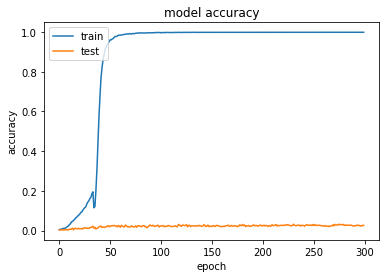

In [11]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
y_pred = np.argmax(model.predict(test_data), axis=1)   
y_label = np.argmax(test_label,axis=1)

In [13]:
confusion_matrix(y_label, y_pred)

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 1]], dtype=int64)

In [14]:
np.trace(confusion_matrix(y_label, y_pred))/(1629)

0.02578268876611418

## fine-tuning with VGG-19

In [15]:
import keras
vgg19 = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = keras.Sequential()
for i in range(0,22):
    model.add(vgg19.layers[i])
for layer in model.layers:
    layer.trainable = False

In [16]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='elu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [18]:
opt = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(train_data, train_label,
                    batch_size=32,
                    validation_data=(test_data, test_label),
                    epochs=300,
                    shuffle=True)

Train on 6515 samples, validate on 1629 samples
Epoch 1/300
6515/6515 [==============================] - 35s 5ms/step - loss: 15.8612 - acc: 0.0109 - val_loss: 15.7889 - val_acc: 0.0129
Epoch 2/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.6437 - acc: 0.0230 - val_loss: 15.7068 - val_acc: 0.0196
Epoch 3/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.5317 - acc: 0.0293 - val_loss: 15.5961 - val_acc: 0.0276
Epoch 4/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.4137 - acc: 0.0385 - val_loss: 15.5833 - val_acc: 0.0282
Epoch 5/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.2967 - acc: 0.0451 - val_loss: 15.3965 - val_acc: 0.0387
Epoch 6/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.1510 - acc: 0.0513 - val_loss: 15.3238 - val_acc: 0.0381
Epoch 7/300
6515/6515 [==============================] - 31s 5ms/step - loss: 15.0702 - acc: 0.0583 - val_loss: 15.4652 - va

6515/6515 [==============================] - 31s 5ms/step - loss: 6.3578 - acc: 0.5948 - val_loss: 12.8768 - val_acc: 0.1670
Epoch 119/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.3264 - acc: 0.5983 - val_loss: 12.8797 - val_acc: 0.1645
Epoch 120/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.2568 - acc: 0.6000 - val_loss: 12.8197 - val_acc: 0.1688
Epoch 121/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.2084 - acc: 0.6037 - val_loss: 12.7773 - val_acc: 0.1737
Epoch 122/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.1471 - acc: 0.6074 - val_loss: 12.7654 - val_acc: 0.1737
Epoch 123/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.0751 - acc: 0.6135 - val_loss: 12.7699 - val_acc: 0.1719
Epoch 124/300
6515/6515 [==============================] - 31s 5ms/step - loss: 6.0879 - acc: 0.6135 - val_loss: 12.6135 - val_acc: 0.1823
Epoch 125/300
6515/6515 [================

6515/6515 [==============================] - 31s 5ms/step - loss: 3.9127 - acc: 0.7495 - val_loss: 12.3488 - val_acc: 0.1952
Epoch 178/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.9290 - acc: 0.7467 - val_loss: 12.2451 - val_acc: 0.2001
Epoch 179/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.8163 - acc: 0.7556 - val_loss: 12.2612 - val_acc: 0.1995
Epoch 180/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.8427 - acc: 0.7558 - val_loss: 12.2596 - val_acc: 0.1958
Epoch 181/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.8230 - acc: 0.7575 - val_loss: 12.2216 - val_acc: 0.2020
Epoch 182/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.8112 - acc: 0.7549 - val_loss: 12.2345 - val_acc: 0.2081
Epoch 183/300
6515/6515 [==============================] - 31s 5ms/step - loss: 3.7348 - acc: 0.7598 - val_loss: 12.2447 - val_acc: 0.1995
Epoch 184/300
6515/6515 [================

6515/6515 [==============================] - 31s 5ms/step - loss: 2.4188 - acc: 0.8451 - val_loss: 11.6863 - val_acc: 0.2302
Epoch 237/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.3916 - acc: 0.8462 - val_loss: 11.7486 - val_acc: 0.2247
Epoch 238/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.3381 - acc: 0.8502 - val_loss: 11.7659 - val_acc: 0.2296
Epoch 239/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.3174 - acc: 0.8503 - val_loss: 11.6734 - val_acc: 0.2357
Epoch 240/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.3156 - acc: 0.8523 - val_loss: 11.7074 - val_acc: 0.2357
Epoch 241/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.2931 - acc: 0.8536 - val_loss: 11.6421 - val_acc: 0.2406
Epoch 242/300
6515/6515 [==============================] - 31s 5ms/step - loss: 2.2949 - acc: 0.8526 - val_loss: 11.6884 - val_acc: 0.2284
Epoch 243/300
6515/6515 [================

6515/6515 [==============================] - 31s 5ms/step - loss: 1.7241 - acc: 0.8887 - val_loss: 11.6424 - val_acc: 0.2308
Epoch 296/300
6515/6515 [==============================] - 31s 5ms/step - loss: 1.7368 - acc: 0.8892 - val_loss: 11.7152 - val_acc: 0.2339
Epoch 297/300
6515/6515 [==============================] - 31s 5ms/step - loss: 1.7280 - acc: 0.8901 - val_loss: 11.6671 - val_acc: 0.2388
Epoch 298/300
6515/6515 [==============================] - 31s 5ms/step - loss: 1.7406 - acc: 0.8886 - val_loss: 11.7597 - val_acc: 0.2271
Epoch 299/300
6515/6515 [==============================] - 31s 5ms/step - loss: 1.7096 - acc: 0.8899 - val_loss: 11.5067 - val_acc: 0.2443
Epoch 300/300
6515/6515 [==============================] - 31s 5ms/step - loss: 1.6941 - acc: 0.8910 - val_loss: 11.4724 - val_acc: 0.2455


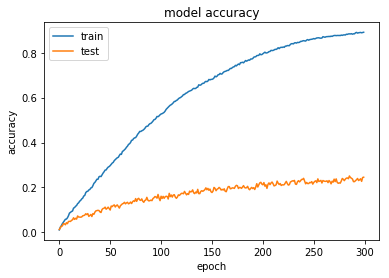

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
y_pred = np.argmax(model.predict(test_data), axis=1)   
y_label = np.argmax(test_label,axis=1)

In [21]:
def print_confusion_matrix(confusion_matrix, class_names, 
                           figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [22]:
confusion_matrix(y_label, y_pred)

array([[9, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 4, 0, 0],
       [0, 0, 0, ..., 0, 4, 0],
       [0, 0, 0, ..., 0, 0, 6]], dtype=int64)

In [23]:
np.trace(confusion_matrix(y_label, y_pred))/(1629)

0.24554941682013506

## VGG with simple attention activation

In [9]:
#Get attention map
def global_average_pooling(x):
    return K.mean(x, axis = (1, 2))

def global_average_pooling_shape(input_shape):
    return (input_shape[0],input_shape[3])

In [15]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = Sequential()
for i in range(0,22):
    model.add(vgg19.layers[i])
for layer in model.layers:
    layer.trainable = False

#Add attention activation
model.add(Lambda(global_average_pooling, output_shape=global_average_pooling_shape))
model.add(Dense(num_classes, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [16]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=2e-7)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(train_data, train_label,
                    batch_size=32,
                    validation_data=(test_data, test_label),
                    epochs=200,
                    shuffle=True)

Train on 6515 samples, validate on 1629 samples
Epoch 1/200
6515/6515 [==============================] - 36s 5ms/sample - loss: 11.0227 - acc: 0.0060 - val_loss: 10.7362 - val_acc: 0.0104
Epoch 2/200
6515/6515 [==============================] - 37s 6ms/sample - loss: 9.1506 - acc: 0.0109 - val_loss: 9.9799 - val_acc: 0.0147
Epoch 3/200
6515/6515 [==============================] - 36s 5ms/sample - loss: 8.2634 - acc: 0.0161 - val_loss: 9.3297 - val_acc: 0.0147
Epoch 4/200
6515/6515 [==============================] - 33s 5ms/sample - loss: 7.5116 - acc: 0.0272 - val_loss: 8.8011 - val_acc: 0.0196
Epoch 5/200
6515/6515 [==============================] - 35s 5ms/sample - loss: 6.8663 - acc: 0.0399 - val_loss: 8.3420 - val_acc: 0.0246
Epoch 6/200
6515/6515 [==============================] - 36s 6ms/sample - loss: 6.3164 - acc: 0.0536 - val_loss: 7.8959 - val_acc: 0.0368
Epoch 7/200
6515/6515 [==============================] - 37s 6ms/sample - loss: 5.8240 - acc: 0.0732 - val_loss: 7.5538 - 

Epoch 118/200
6515/6515 [==============================] - 32s 5ms/sample - loss: 0.1310 - acc: 0.9725 - val_loss: 4.8646 - val_acc: 0.3186
Epoch 119/200
6515/6515 [==============================] - 36s 6ms/sample - loss: 0.1283 - acc: 0.9719 - val_loss: 4.8488 - val_acc: 0.3186
Epoch 120/200
6515/6515 [==============================] - 37s 6ms/sample - loss: 0.1258 - acc: 0.9730 - val_loss: 4.9041 - val_acc: 0.3137
Epoch 121/200
6515/6515 [==============================] - 38s 6ms/sample - loss: 0.1251 - acc: 0.9727 - val_loss: 4.8838 - val_acc: 0.3186
Epoch 122/200
6515/6515 [==============================] - 38s 6ms/sample - loss: 0.1213 - acc: 0.9733 - val_loss: 4.9092 - val_acc: 0.3168
Epoch 123/200
6515/6515 [==============================] - 38s 6ms/sample - loss: 0.1200 - acc: 0.9742 - val_loss: 4.9067 - val_acc: 0.3241
Epoch 124/200
6515/6515 [==============================] - 38s 6ms/sample - loss: 0.1172 - acc: 0.9725 - val_loss: 4.9274 - val_acc: 0.3204
Epoch 125/200
6515/6

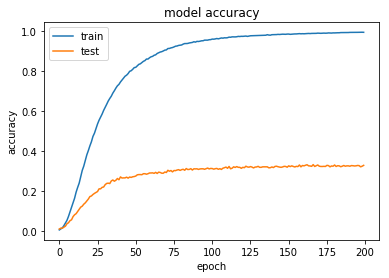

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
y_pred = np.argmax(model.predict(test_data), axis=1)   
y_label = np.argmax(test_label,axis=1)

In [19]:
confusion_matrix(y_label, y_pred)

array([[8, 0, 0, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       [0, 1, 2, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 5, 0, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 0, 3]], dtype=int64)

In [20]:
np.trace(confusion_matrix(y_label, y_pred))/(1629)

0.3284223449969306

In [129]:
def attention_map(data, data_num, conv_layer, category = None):
    data_resize = np.array([data])
    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    
    #Get the output of the image from the last convolution layer
    intermediate_layer_model = Model(inputs=model.layers[0].input,
                                 outputs=model.layers[conv_layer].output)
    conv_outputs = intermediate_layer_model.predict(data_resize)
    
    #Use Bilinear Upsampling to convert the attention map to input image size
    conv_outputs = resize_images(conv_outputs,(224,224))
    
    #Get the prediction of the model
    intermediate_layer_model2 = Model(inputs=model.layers[0].input,
                                 outputs=model.layers[-1].output)
    prediction = intermediate_layer_model2.predict(data_resize)
    predicted_category = np.argmax(prediction)
    
    #Create attention map
    cam = np.zeros(dtype = np.float32, shape = (224,224))
    target_class = np.where(train_label[data_num]==1)[0][0]
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[0,:, :, i]
        
    #Create attention map for predicted category    
    cam_p = np.zeros(dtype = np.float32, shape = (224,224))
    target_class = predicted_category
    for i, w in enumerate(class_weights[:, target_class]):
        cam_p += w * conv_outputs[0,:, :, i]
        
    return data, cam, cam_p

In [130]:
def random_examples(data,conv_layer,sample_size=5):
    plt.figure(figsize=(16, 16))    
    num_data = data.shape[0]
    for i in range(0, sample_size):
        data_num = random.randint(0,num_data)
        ori_img,cam,cam_p = attention_map(data[data_num],data_num,conv_layer)
        plt.subplot(sample_size, 2, 2*i+1)
        plt.imshow(ori_img)
        plt.imshow(Session().run(cam), cmap='jet', alpha=0.5, interpolation='nearest')
        plt.subplot(sample_size, 2, 2*i+2)
        plt.imshow(ori_img)
        plt.imshow(Session().run(cam_p), cmap='jet', alpha=0.5, interpolation='nearest')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

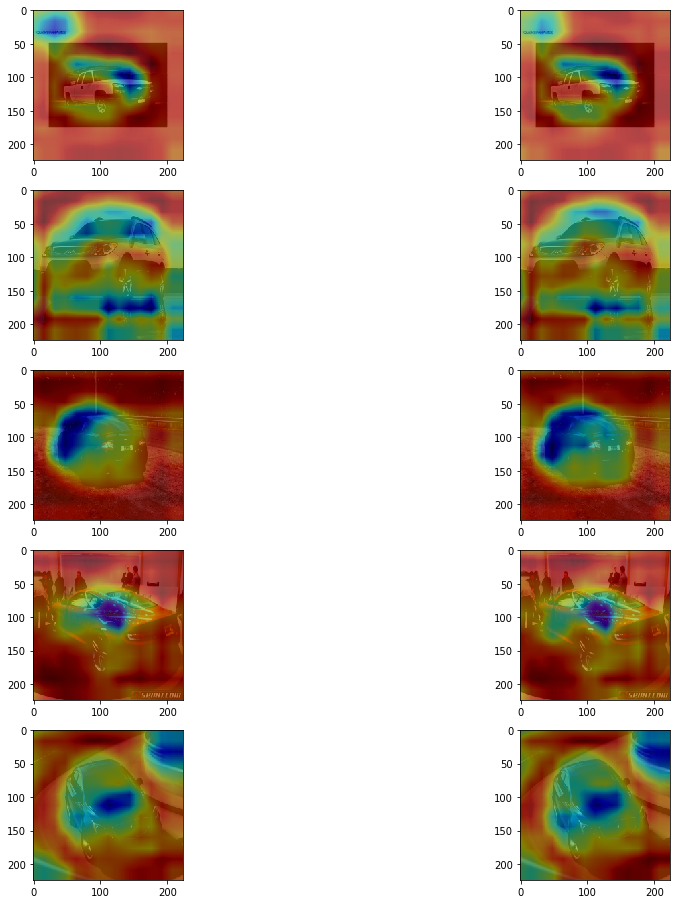

In [111]:
#Visualize the attention on images
random_examples(test_data_ori, 19, sample_size=5)

## Data Augmentation with attention

In [113]:
def attention_generation(args):
    x = args
    x = K.mean(x, axis = 3)
    x = expand_dims(x,3)
    x = K.repeat_elements(x,3,axis=3)
    return x

def att_shape(input_shape):
    return (input_shape[0:3])

In [116]:
inputs = Input(shape=(224,224,3))
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
global_pooling = Lambda(global_average_pooling, output_shape=global_average_pooling_shape,name='gp')
fc_layer = Dense(512, activation = 'elu')
activation = Dense(num_classes, activation = 'softmax', name='acti')

model_vgg = Sequential()
for i in range(0,22):
    model_vgg.add(vgg19.layers[i])
for layer in model_vgg.layers:
    layer.trainable = False
feature_map = model_vgg(inputs)
attention = global_pooling(feature_map)
attention = fc_layer(attention)
attention = Dropout(0.2)(attention)
result = activation(attention)

#Attention Augmentation on origial image
att_map = Lambda(attention_generation,output_shape=att_shape)(feature_map)
att_map = UpSampling2D(size=(32,32))(att_map)
aug_data = Multiply()([att_map,inputs])

#Feed to original neural network.
x_aug = model_vgg(aug_data)
global_pooling_aug = global_pooling(x_aug)
global_pooling_aug = fc_layer(global_pooling_aug)
global_pooling_aug = Dropout(0.2)(global_pooling_aug)
result2 = activation(global_pooling_aug)

model = Model(inputs=inputs,outputs=result2)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 7, 7, 512)    20024384    input_8[0][0]                    
                                                                 multiply_2[0][0]                 
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 7, 7, 3)      0           sequential_5[1][0]               
__________________________________________________________________________________________________
up_sampling2d_2 (UpSampling2D)  (None, 224, 224, 3)  0           lambda_5[0][0]                   
__________

In [117]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model.fit(train_data, train_label,
                    batch_size=32,
                    validation_data=(test_data, test_label),
                    epochs=150,
                    shuffle=True)

Train on 6515 samples, validate on 1629 samples
Epoch 1/150
6515/6515 [==============================] - 96s 15ms/sample - loss: 15.5537 - acc: 0.0078 - val_loss: 14.7257 - val_acc: 0.0061
Epoch 2/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 15.1447 - acc: 0.0135 - val_loss: 14.1301 - val_acc: 0.0147
Epoch 3/150
6515/6515 [==============================] - 63s 10ms/sample - loss: 14.5769 - acc: 0.0215 - val_loss: 13.5381 - val_acc: 0.0166
Epoch 4/150
6515/6515 [==============================] - 62s 9ms/sample - loss: 13.7351 - acc: 0.0325 - val_loss: 12.1712 - val_acc: 0.0203
Epoch 5/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 11.4913 - acc: 0.0379 - val_loss: 8.4693 - val_acc: 0.0190
Epoch 6/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 6.9442 - acc: 0.0252 - val_loss: 5.8502 - val_acc: 0.0160
Epoch 7/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 5.6659 - acc: 0.0235 - val_lo

6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0568 - acc: 0.9905 - val_loss: 4.7878 - val_acc: 0.2167
Epoch 118/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0553 - acc: 0.9905 - val_loss: 4.7295 - val_acc: 0.2228
Epoch 119/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0566 - acc: 0.9889 - val_loss: 4.7510 - val_acc: 0.2179
Epoch 120/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0545 - acc: 0.9900 - val_loss: 4.7953 - val_acc: 0.2222
Epoch 121/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0524 - acc: 0.9899 - val_loss: 4.8418 - val_acc: 0.2155
Epoch 122/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0524 - acc: 0.9897 - val_loss: 4.8058 - val_acc: 0.2198
Epoch 123/150
6515/6515 [==============================] - 62s 10ms/sample - loss: 0.0528 - acc: 0.9893 - val_loss: 4.7856 - val_acc: 0.2149
Epoch 124/150
6515/6515 [==

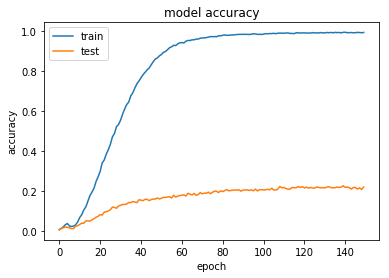

In [118]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
y_pred = np.argmax(model.predict(test_data), axis=1)   
y_label = np.argmax(test_label,axis=1)

In [120]:
confusion_matrix(y_label, y_pred)

array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 6, 0, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 4]], dtype=int64)

In [121]:
np.trace(confusion_matrix(y_label, y_pred))/(1629)

0.2203806015960712

In [137]:
def attention_map_aug(data, data_num, category = None):
    data_resize = np.array([data])
    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    
    #Get the output of the image from the VGG layer
    intermediate_layer_model = Model(inputs=model_vgg.input,
                                 outputs=model_vgg.output)
    conv_outputs = intermediate_layer_model.predict(data_resize)
    
    #Use Bilinear Upsampling to convert the attention map to input image size
    conv_outputs = resize_images(conv_outputs,(224,224))
    
    #Get the prediction of the model
    intermediate_layer_model2 = Model(inputs=model.layers[0].input,
                                 outputs=model.layers[-1].output)
    prediction = intermediate_layer_model2.predict(data_resize)
    predicted_category = np.argmax(prediction)
    
    #Create attention map
    cam = np.zeros(dtype = np.float32, shape = (224,224))
    target_class = np.where(train_label[data_num]==1)[0][0]
    for i, w in enumerate(class_weights[:, target_class]):
        cam += w * conv_outputs[0,:, :, i]
    
    #Create attention map for predicted category
    cam_p = np.zeros(dtype = np.float32, shape = (224,224))
    target_class = predicted_category
    for i, w in enumerate(class_weights[:, target_class]):
        cam_p += w * conv_outputs[0,:, :, i]
        
    return data, cam, cam_p

def random_examples_aug(data, sample_size=5):
    plt.figure(figsize=(16, 16))    
    num_data = data.shape[0]
    for i in range(0, sample_size):
        data_num = random.randint(0,num_data)
        ori_img,cam,cam_p = attention_map_aug(data[data_num],data_num)
        plt.subplot(sample_size, 2, 2*i+1)
        plt.imshow(ori_img)
        plt.imshow(Session().run(cam), cmap='jet', alpha=0.5, interpolation='nearest')
        plt.subplot(sample_size, 2, 2*i+2)
        plt.imshow(ori_img)
        plt.imshow(Session().run(cam_p), cmap='jet', alpha=0.5, interpolation='nearest')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

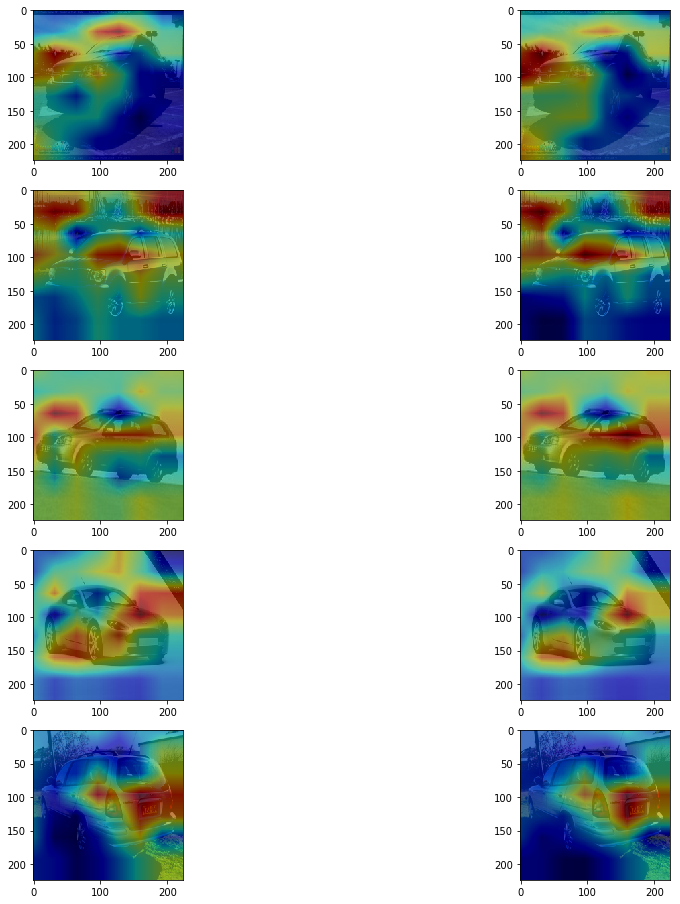

In [138]:
random_examples_aug(test_data_ori, sample_size=5)

## Data Augmentation with attention 2

In [51]:
def attention_generation2(args, channel = 512):
    x = args
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1,1,channel))(x)
    return x

def att_shape2(input_shape,channel = 512):
    return ((1,1,channel))

In [52]:
inputs = Input(shape=(224,224,3))
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = Sequential()
for i in range(0,21):
    model.add(vgg19.layers[i])
for layer in model.layers:
    layer.trainable = False
feature_map = model(inputs)
y = MaxPooling2D(pool_size=(2, 2))(feature_map)
global_pooling = Lambda(global_average_pooling, output_shape=global_average_pooling_shape,name='gp')
fc_layer = Dense(512, activation = 'elu')
activation = Dense(num_classes, activation = 'softmax', name='acti')
attention = global_pooling(y)
attention = fc_layer(attention)
attention = Dropout(0.5)(attention)
result = activation(attention)

#Augment feature map
att_map = Conv2D(512, (1, 1))(feature_map)
att_map = Lambda(attention_generation2,output_shape=att_shape2)(att_map)
aug_data = Multiply()([att_map,feature_map])
feature_aug = MaxPooling2D(pool_size=(2, 2))(aug_data)
global_pooling_aug = global_pooling(feature_aug)
global_pooling_aug = fc_layer(global_pooling_aug)
global_pooling_aug = Dropout(0.5)(global_pooling_aug)
result_final = activation(global_pooling_aug)


model_final = Model(inputs=inputs,outputs=result_final)
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 14, 14, 512)  20024384    input_28[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 14, 14, 512)  262656      sequential_14[1][0]              
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, 1, 1, 512)    0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
multiply_1

In [53]:
opt = tensorflow.keras.optimizers.RMSprop(lr=0.0001, decay=2e-7)
model_final.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
history = model_final.fit(train_data, train_label,
                    batch_size=32,
                    validation_data=(test_data, test_label),
                    epochs=300,
                    shuffle=True)

Train on 6515 samples, validate on 1629 samples
Epoch 1/300
6515/6515 [==============================] - 32s 5ms/sample - loss: 12.6502 - acc: 0.0066 - val_loss: 9.8405 - val_acc: 0.0092
Epoch 2/300
6515/6515 [==============================] - 35s 5ms/sample - loss: 9.0460 - acc: 0.0138 - val_loss: 7.9216 - val_acc: 0.0117
Epoch 3/300
6515/6515 [==============================] - 38s 6ms/sample - loss: 7.3707 - acc: 0.0235 - val_loss: 6.8502 - val_acc: 0.0246
Epoch 4/300
6515/6515 [==============================] - 38s 6ms/sample - loss: 6.3367 - acc: 0.0364 - val_loss: 6.2376 - val_acc: 0.0393
Epoch 5/300
6515/6515 [==============================] - 37s 6ms/sample - loss: 5.6462 - acc: 0.0505 - val_loss: 5.8326 - val_acc: 0.0473
Epoch 6/300
6515/6515 [==============================] - 37s 6ms/sample - loss: 5.1661 - acc: 0.0754 - val_loss: 5.6021 - val_acc: 0.0577
Epoch 7/300
6515/6515 [==============================] - 38s 6ms/sample - loss: 4.7765 - acc: 0.1028 - val_loss: 5.4269 - v

Epoch 118/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0662 - acc: 0.9850 - val_loss: 6.3498 - val_acc: 0.2253
Epoch 119/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0569 - acc: 0.9873 - val_loss: 6.3904 - val_acc: 0.2284
Epoch 120/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0592 - acc: 0.9876 - val_loss: 6.3580 - val_acc: 0.2351
Epoch 121/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0662 - acc: 0.9862 - val_loss: 6.3450 - val_acc: 0.2308
Epoch 122/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0648 - acc: 0.9842 - val_loss: 6.3424 - val_acc: 0.2302
Epoch 123/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0558 - acc: 0.9883 - val_loss: 6.3335 - val_acc: 0.2296
Epoch 124/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0613 - acc: 0.9854 - val_loss: 6.3607 - val_acc: 0.2277
Epoch 125/300
6515/6

6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0276 - acc: 0.9934 - val_loss: 7.2873 - val_acc: 0.2431
Epoch 235/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0215 - acc: 0.9945 - val_loss: 7.3871 - val_acc: 0.2431
Epoch 236/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0251 - acc: 0.9939 - val_loss: 7.2631 - val_acc: 0.2394
Epoch 237/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0272 - acc: 0.9936 - val_loss: 7.2714 - val_acc: 0.2437
Epoch 238/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0276 - acc: 0.9928 - val_loss: 7.3515 - val_acc: 0.2388
Epoch 239/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0261 - acc: 0.9931 - val_loss: 7.2733 - val_acc: 0.2431
Epoch 240/300
6515/6515 [==============================] - 29s 4ms/sample - loss: 0.0308 - acc: 0.9920 - val_loss: 7.2344 - val_acc: 0.2455
Epoch 241/300
6515/6515 [=========